In [57]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [58]:
# Load Preprocessed .npy Files

base_path = os.path.join(os.path.dirname(__file__), 'data') if '__file__' in globals() else 'data/'
audio_train = np.load(os.path.join(base_path, "audio_filtered_train.npy"), allow_pickle=True).item()
audio_val = np.load(os.path.join(base_path, "audio_filtered_val.npy"), allow_pickle=True).item()
audio_test = np.load(os.path.join(base_path, "audio_filtered_test.npy"), allow_pickle=True).item()

rgb_train = np.load(os.path.join(base_path, "rgb_filtered_train.npy"), allow_pickle=True).item()
rgb_val = np.load(os.path.join(base_path, "rgb_filtered_val.npy"), allow_pickle=True).item()
rgb_test = np.load(os.path.join(base_path, "rgb_filtered_test.npy"), allow_pickle=True).item()

flow_train = np.load(os.path.join(base_path, "flow_filtered_train.npy"), allow_pickle=True).item()
flow_val = np.load(os.path.join(base_path, "flow_filtered_val.npy"), allow_pickle=True).item()
flow_test = np.load(os.path.join(base_path, "flow_filtered_test.npy"), allow_pickle=True).item()


In [59]:
# Dataset Definition

class VideoToAudioDataset(Dataset):
    def __init__(self, rgb_dict, flow_dict, audio_dict):
        self.keys = list(audio_dict.keys())
        self.rgb_dict = rgb_dict
        self.flow_dict = flow_dict
        self.audio_dict = audio_dict

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        rgb_feat = self.rgb_dict[key]      # (18, 768)
        flow_feat = self.flow_dict[key]    # (18, 768)
        x = np.concatenate([rgb_feat, flow_feat], axis=-1)  # (18, 1536)
        y = self.audio_dict[key]           # (18, 128)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), key


In [60]:
# 데이터 불러오기 

train_loader = DataLoader(VideoToAudioDataset(rgb_train, flow_train, audio_train), batch_size=4, shuffle=True)
val_loader = DataLoader(VideoToAudioDataset(rgb_val, flow_val, audio_val), batch_size=4)
test_loader = DataLoader(VideoToAudioDataset(rgb_test, flow_test, audio_test), batch_size=4)


In [61]:
# LSTM-based generator 

class AudioFeatureGenerator(nn.Module):
    def __init__(self, input_dim=1536, hidden_dim=512, num_layers=2, output_dim=128):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)  # (B, 18, H)
        return self.fc(out)    # (B, 18, 128)

In [62]:
# Training & Validation Functions

def sequence_mse_loss(pred, target):
    return ((pred - target) ** 2).mean()

def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for x, y, _ in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)  # (B, 18, 218)
        loss = criterion(pred, y)  # element-wise comparison
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

def validate(model, loader, criterion, device, visualize=False, num_samples=3):
    model.eval()
    total_loss = 0
    samples = []

    with torch.no_grad():
        for i in range(len(loader.dataset)):
            x, y, key = loader.dataset[i]
            x = x.unsqueeze(0).to(device)
            y = y.unsqueeze(0).to(device)
            pred = model(x)
            loss = criterion(pred, y)
            total_loss += loss.item()

            if visualize and len(samples) < num_samples:
                samples.append((key, pred.squeeze(0).cpu().numpy(), y.squeeze(0).cpu().numpy()))

    if visualize:
        visualize_audio_similarity_samples(samples)

    return total_loss / len(loader.dataset)

def visualize_audio_similarity_samples(samples):
    for key, pred, gt in samples:
        cosine_sim = [cosine_similarity(pred[i:i+1], gt[i:i+1])[0, 0] for i in range(18)]
        mse = [np.mean((pred[i] - gt[i]) ** 2) for i in range(18)]

        fig, ax1 = plt.subplots()
        ax1.set_title(f"Similarity & MSE for video {key}")
        ax1.plot(cosine_sim, label='Cosine Similarity', marker='o', color='blue')
        ax1.set_ylim(0, 1)
        ax1.set_ylabel('Cosine Similarity', color='blue')

        ax2 = ax1.twinx()
        ax2.plot(mse, label='MSE', marker='x', color='red')
        ax2.set_ylabel('MSE', color='red')

        fig.tight_layout()
        plt.xlabel('Frame')
        plt.legend()
        plt.show()

In [63]:
# Generated audio feature 저장 함수

def generate_and_save_audio_features(model, dataset, device, save_path):
    model.eval()
    results = {}
    with torch.no_grad():
        for i in range(len(dataset)):
            x, _, key = dataset[i]
            x = x.unsqueeze(0).to(device)
            pred = model(x).cpu().squeeze(0).numpy()  # (18, 128)
            results[key] = pred
    np.save(save_path, results)
    print(f"✅ Saved: {save_path} with {len(results)} samples")

[Epoch 1] Train Loss: 0.1672 | Val Loss: 0.1661
[Epoch 2] Train Loss: 0.1651 | Val Loss: 0.1657
[Epoch 3] Train Loss: 0.1647 | Val Loss: 0.1662
[Epoch 4] Train Loss: 0.1646 | Val Loss: 0.1662
[Epoch 5] Train Loss: 0.1646 | Val Loss: 0.1663
[Epoch 6] Train Loss: 0.1644 | Val Loss: 0.1653
[Epoch 7] Train Loss: 0.1644 | Val Loss: 0.1670
[Epoch 8] Train Loss: 0.1643 | Val Loss: 0.1655
[Epoch 9] Train Loss: 0.1643 | Val Loss: 0.1663


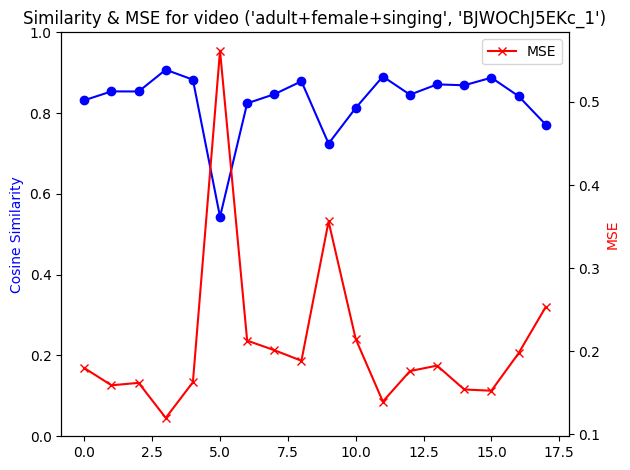

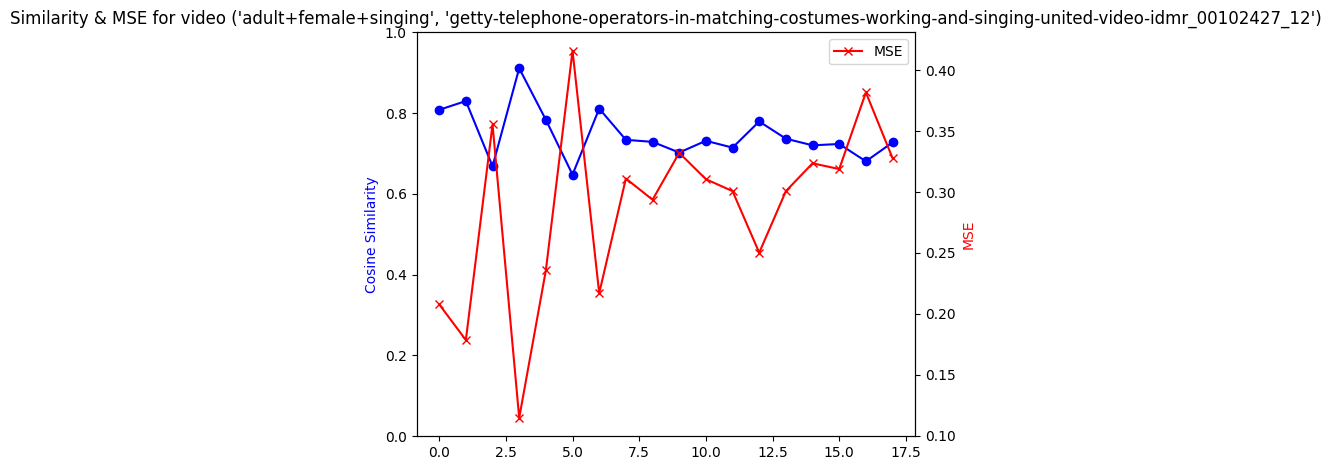

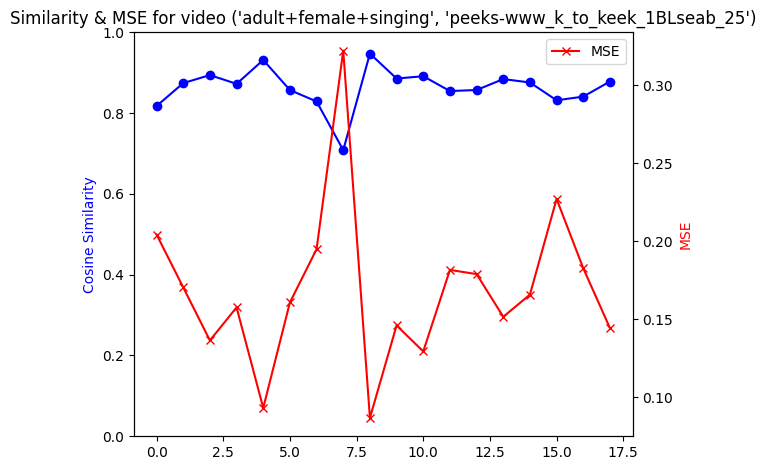

[Epoch 10] Train Loss: 0.1642 | Val Loss: 0.1652


In [64]:
# Run Training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AudioFeatureGenerator().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = sequence_mse_loss

for epoch in range(1, 11):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss = validate(model, val_loader, criterion, device, visualize=(epoch==10), num_samples=3)
    print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")



✅ Final Test Loss: 0.1654


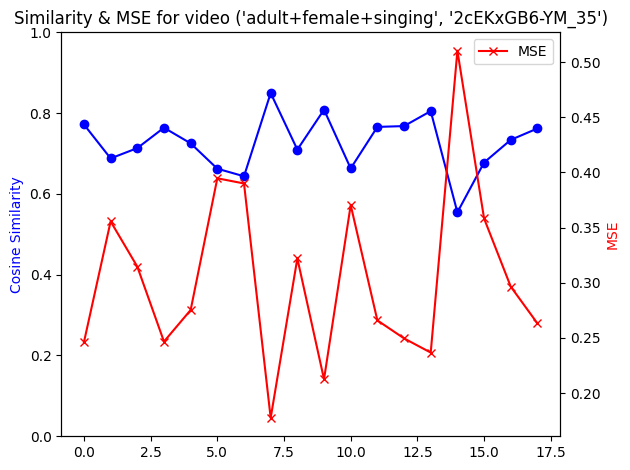

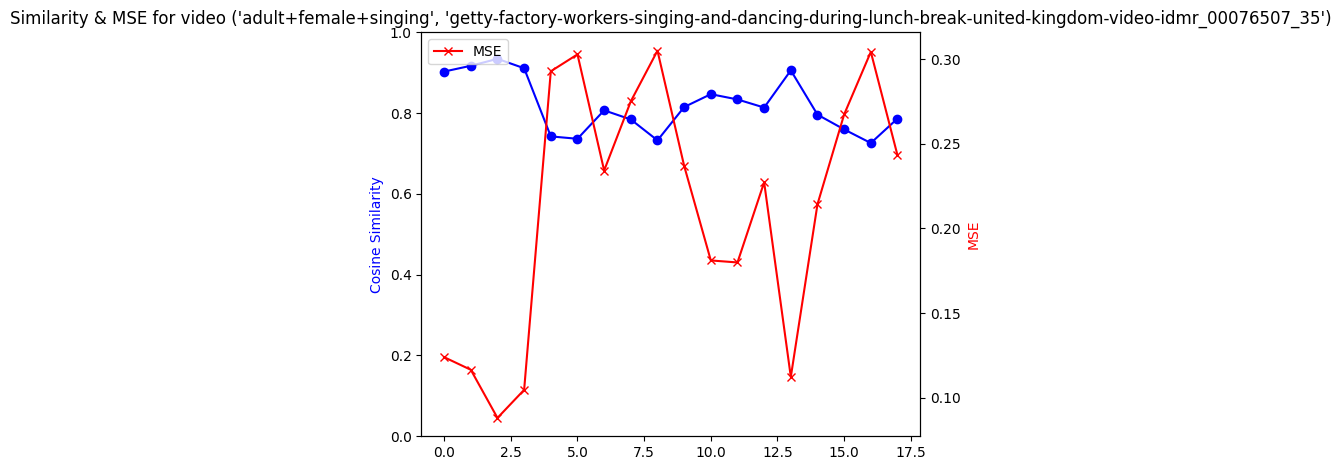

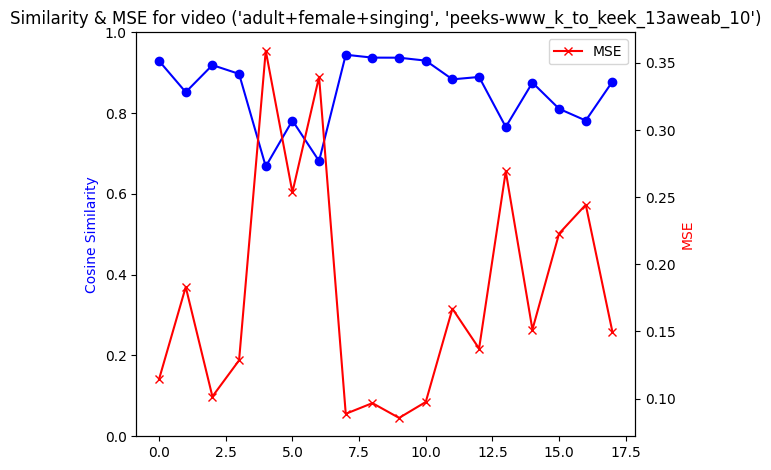

In [65]:
# Final Test Evaluation

def test(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y, _ in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

final_test_loss = test(model, test_loader, criterion, device)
print(f"\n✅ Final Test Loss: {final_test_loss:.4f}")

def test_audio_similarity(model, dataset, device, num_samples=3):
    model.eval()
    samples = []
    with torch.no_grad():
        for i in range(len(dataset)):
            x, y, key = dataset[i]
            x = x.unsqueeze(0).to(device)
            y = y.unsqueeze(0).to(device)
            pred = model(x)

            if len(samples) < num_samples:
                samples.append((key, pred.squeeze(0).cpu().numpy(), y.squeeze(0).cpu().numpy()))
            else:
                break

    visualize_audio_similarity_samples(samples)

test_audio_similarity(model, test_loader.dataset, device, num_samples=3)


In [66]:
# Generated audio feature 저장 함수 호출

generate_and_save_audio_features(model, train_loader.dataset, device, 'gen_audio_train.npy')
generate_and_save_audio_features(model, val_loader.dataset, device, 'gen_audio_val.npy')
generate_and_save_audio_features(model, test_loader.dataset, device, 'gen_audio_test.npy')

✅ Saved: gen_audio_train.npy with 9074 samples
✅ Saved: gen_audio_val.npy with 1937 samples
✅ Saved: gen_audio_test.npy with 1967 samples


In [67]:
# Action Recognition Dataset

class ActionRecognitionDataset(torch.utils.data.Dataset):
    def __init__(self, rgb_dict, flow_dict, audio_dict=None):
        self.keys = list(rgb_dict.keys())
        self.rgb_dict = rgb_dict
        self.flow_dict = flow_dict
        self.audio_dict = audio_dict  # None if audio is not used
        self.use_audio = audio_dict is not None
        self.label_map = {cls: i for i, cls in enumerate(sorted(set(k[0] for k in self.keys)))}

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        rgb = self.rgb_dict[key]      # (18, 768)
        flow = self.flow_dict[key]    # (18, 768)
        x = np.concatenate([rgb, flow], axis=-1)  # (18, 1536)

        if self.use_audio:
            audio = self.audio_dict[key]  # (18, 128)
            x = np.concatenate([x, audio], axis=-1)  # (18, 1664)

        label = self.label_map[key[0]]  # class_name → int label
        return torch.tensor(x, dtype=torch.float32), label


In [69]:
# Action Recognition Dataset Loaders

gen_audio_train = np.load(os.path.join(base_path, 'gen_audio_train.npy'), allow_pickle=True).item()
gen_audio_val = np.load(os.path.join(base_path, 'gen_audio_val.npy'), allow_pickle=True).item()
gen_audio_test = np.load(os.path.join(base_path, 'gen_audio_test.npy'), allow_pickle=True).item()

# No Audio Datasets
no_audio_train = ActionRecognitionDataset(rgb_train, flow_train)
no_audio_val = ActionRecognitionDataset(rgb_val, flow_val)
no_audio_test = ActionRecognitionDataset(rgb_test, flow_test)

# With Generated Audio Datasets
gen_audio_train_ds = ActionRecognitionDataset(rgb_train, flow_train, gen_audio_train)
gen_audio_val_ds = ActionRecognitionDataset(rgb_val, flow_val, gen_audio_val)
gen_audio_test_ds = ActionRecognitionDataset(rgb_test, flow_test, gen_audio_test)

# DataLoaders
no_audio_train_loader = DataLoader(no_audio_train, batch_size=16, shuffle=True)
no_audio_val_loader = DataLoader(no_audio_val, batch_size=16)
no_audio_test_loader = DataLoader(no_audio_test, batch_size=16)

gen_audio_train_loader = DataLoader(gen_audio_train_ds, batch_size=16, shuffle=True)
gen_audio_val_loader = DataLoader(gen_audio_val_ds, batch_size=16)
gen_audio_test_loader = DataLoader(gen_audio_test_ds, batch_size=16)

In [70]:
# Action Recognition Classifier

class ActionClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_classes=20):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=1, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)  # (B, 18, hidden_dim)
        last_hidden = out[:, -1, :]  # (B, hidden_dim)
        return self.fc(last_hidden)  # (B, num_classes)


In [71]:
# 학습 및 평가 함수

def train_classifier(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        correct += (pred.argmax(1) == y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def evaluate_classifier(model, loader, criterion, device):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            total_loss += loss.item() * x.size(0)
            correct += (pred.argmax(1) == y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

In [ ]:
# No Audio

model = ActionClassifier(input_dim=1536).to(device)  
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, 11):
    train_loss, train_acc = train_classifier(model, no_audio_train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate_classifier(model, no_audio_val_loader, criterion, device)
    print(f"[Epoch {epoch}] Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

test_loss, test_acc = evaluate_classifier(model, no_audio_test_loader, criterion, device)
print(f"\n✅ Final Test Accuracy (No Audio): {test_acc:.4f}")

c:\ProgramData\Anaconda3\envs\TeamPossible\lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Epoch 1] Train Acc: 0.1455 | Val Acc: 0.1595
[Epoch 2] Train Acc: 0.1637 | Val Acc: 0.1606
[Epoch 3] Train Acc: 0.1746 | Val Acc: 0.1729
[Epoch 4] Train Acc: 0.1788 | Val Acc: 0.1750
[Epoch 5] Train Acc: 0.1817 | Val Acc: 0.1729
[Epoch 6] Train Acc: 0.1822 | Val Acc: 0.1802
[Epoch 7] Train Acc: 0.1864 | Val Acc: 0.1745
[Epoch 8] Train Acc: 0.1889 | Val Acc: 0.1900
[Epoch 9] Train Acc: 0.1918 | Val Acc: 0.1755
[Epoch 10] Train Acc: 0.1933 | Val Acc: 0.1729

✅ Final Test Accuracy (No Audio): 0.1779


In [75]:
# Gen Audio

model = ActionClassifier(input_dim=1664).to(device)  
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, 11):
    train_loss, train_acc = train_classifier(model, gen_audio_train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate_classifier(model, gen_audio_val_loader, criterion, device)
    print(f"[Epoch {epoch}] Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

test_loss, test_acc = evaluate_classifier(model, gen_audio_test_loader, criterion, device)
print(f"\n✅ Final Test Accuracy (Gen Audio): {test_acc:.4f}")


[Epoch 1] Train Acc: 0.1433 | Val Acc: 0.1492
[Epoch 2] Train Acc: 0.1643 | Val Acc: 0.1538
[Epoch 3] Train Acc: 0.1704 | Val Acc: 0.1797
[Epoch 4] Train Acc: 0.1753 | Val Acc: 0.1662
[Epoch 5] Train Acc: 0.1772 | Val Acc: 0.1791
[Epoch 6] Train Acc: 0.1791 | Val Acc: 0.1807
[Epoch 7] Train Acc: 0.1845 | Val Acc: 0.1693
[Epoch 8] Train Acc: 0.1861 | Val Acc: 0.1812
[Epoch 9] Train Acc: 0.1855 | Val Acc: 0.1791
[Epoch 10] Train Acc: 0.1897 | Val Acc: 0.1729

✅ Final Test Accuracy (Gen Audio): 0.1856


In [76]:
# GT 오디오를 활용한 Action Recognition 평가용 Dataset 로딩

audio_train_gt = np.load(os.path.join(base_path, "audio_filtered_train.npy"), allow_pickle=True).item()
audio_val_gt = np.load(os.path.join(base_path, "audio_filtered_val.npy"), allow_pickle=True).item()
audio_test_gt = np.load(os.path.join(base_path, "audio_filtered_test.npy"), allow_pickle=True).item()

gt_audio_train_ds = ActionRecognitionDataset(rgb_train, flow_train, audio_train_gt)
gt_audio_val_ds = ActionRecognitionDataset(rgb_val, flow_val, audio_val_gt)
gt_audio_test_ds = ActionRecognitionDataset(rgb_test, flow_test, audio_test_gt)

gt_audio_train_loader = DataLoader(gt_audio_train_ds, batch_size=16, shuffle=True)
gt_audio_val_loader = DataLoader(gt_audio_val_ds, batch_size=16)
gt_audio_test_loader = DataLoader(gt_audio_test_ds, batch_size=16)

In [77]:
# GT 오디오로 ActionClassifier 학습 예시
model = ActionClassifier(input_dim=1664).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, 11):
     train_loss, train_acc = train_classifier(model, gt_audio_train_loader, optimizer, criterion, device)
     val_loss, val_acc = evaluate_classifier(model, gt_audio_val_loader, criterion, device)
     print(f"[Epoch {epoch}] Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

test_loss, test_acc = evaluate_classifier(model, gt_audio_test_loader, criterion, device)
print(f"✅ Final Test Accuracy (GT Audio): {test_acc:.4f}")


[Epoch 1] Train Acc: 0.1615 | Val Acc: 0.1869
[Epoch 2] Train Acc: 0.2334 | Val Acc: 0.2628
[Epoch 3] Train Acc: 0.2737 | Val Acc: 0.2896
[Epoch 4] Train Acc: 0.2985 | Val Acc: 0.2907
[Epoch 5] Train Acc: 0.3138 | Val Acc: 0.3067
[Epoch 6] Train Acc: 0.3168 | Val Acc: 0.3072
[Epoch 7] Train Acc: 0.3318 | Val Acc: 0.3211
[Epoch 8] Train Acc: 0.3405 | Val Acc: 0.3371
[Epoch 9] Train Acc: 0.3410 | Val Acc: 0.3320
[Epoch 10] Train Acc: 0.3489 | Val Acc: 0.3407
✅ Final Test Accuracy (GT Audio): 0.3432
